In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import xgboost as xgb
import bisect

from scipy import stats
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

In [2]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv').drop(['X1'], axis=1)
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv').drop(['Id', 'X1'], axis=1)

display(train.head())
display(test.head())

,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,42.9,58.7,14.5,A,4,23,PL233,232,1564


,X2,X3,X4,X5,X6,X7,X8
0,80.6,104.8,11.0,A,29,23,PL234
1,141.8,34.2,17.5,A,2,91,PL911
2,77.2,103.3,17.0,A,10,97,PL973
3,95.5,131.0,18.0,A,2,23,PL234
4,91.7,36.1,19.0,AH32,1,27,PL271


| 항목 | 설명     |
|-----|----------|
| X1  | 작업번호 |
| X2  | 마킹길이 |
| X3  | 절단길이 |
| X4  | 철판두께 |
| X5  | 철판재질 |
| X6  | 절단갯수 |
| X7  | 작업장   |
| X8  | 작업자   |
| Y1  | 마킹시간 |
| Y2  | 절단시간 |

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X2      121754 non-null  float64
 1   X3      121754 non-null  float64
 2   X4      121754 non-null  float64
 3   X5      121754 non-null  object 
 4   X6      121754 non-null  int64  
 5   X7      121754 non-null  int64  
 6   X8      121754 non-null  object 
 7   Y1      121754 non-null  int64  
 8   Y2      121754 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 8.4+ MB


In [4]:
train.describe()

,X2,X3,X4,X6,X7,Y1,Y2
count,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,1.217540e+05,121754.000000
mean,77.608615,73.875636,17.444897,13.630049,43.921152,8.971671e+02,2193.206638
std,48.006125,53.267359,4.498316,20.751914,32.509414,4.604704e+04,2299.585390
min,3.200000,1.800000,6.000000,1.000000,14.000000,0.000000e+00,0.000000
25%,45.200000,40.900000,14.500000,1.000000,22.000000,2.380000e+02,1064.000000
50%,68.100000,52.800000,17.000000,4.000000,25.000000,3.790000e+02,1593.000000
75%,98.300000,93.000000,20.000000,18.000000,91.000000,5.480000e+02,2778.000000
max,524.400000,621.300000,40.000000,416.000000,97.000000,6.157364e+06,348262.000000


In [5]:
train['X4'].unique()

array([22.5, 13. , 18. , 15. , 14.5, 14. , 21. , 19.5, 19. , 20.5, 16. ,
       20. , 25. , 13.5, 11. , 12. , 28. , 30. , 15.5, 17. , 10. , 22. ,
       21.5, 23. , 15.1, 34. , 27. , 18.5, 26. , 26.5, 12.5, 17.5, 24. ,
       36. , 25.5, 23.5, 16.5,  9. ,  6. , 24.5, 32. ,  8.1, 35. , 10.5,
       11.5,  7.1, 31. ,  7. ,  8. ,  9.5, 35.5, 28.5, 34.5, 27.5, 33. ,
       29.5, 29. , 30.5, 20.1, 32.5, 33.5, 31.5, 40. ])

# 특징 만들기


In [6]:
# train['X8'] = train['X8'].str.extract(r'(PL|PS)')
# test['X8'] = test['X8'].str.extract(r'(PL|PS)')

In [7]:
# train['X8_encoded'] = (train['X8'] != 'PL').astype(int)
# test['X8_encoded'] = (test['X8'] != 'PL').astype(int)

# train = pd.get_dummies(train, columns=['X8_encoded'], prefix=['X8'])
# test = pd.get_dummies(test, columns=['X8_encoded'], prefix=['X8'])

# train[['X8_0', 'X8_1']] = train[['X8_0', 'X8_1']].astype(int)
# test[['X8_0', 'X8_1']] = test[['X8_0', 'X8_1']].astype(int)

In [8]:
mmtime = train.groupby('X5')['Y1'].mean()
mctime = train.groupby('X5')['Y2'].mean()

wmtime = train.groupby('X7')['Y1'].mean()
wctime = train.groupby('X7')['Y2'].mean()

manmtime = train.groupby('X8')['Y1'].mean()
manctime = train.groupby('X8')['Y2'].mean()

train['X5_mmtime'] = train['X5'].map(mmtime)
train['X5_mctime'] = train['X5'].map(mctime)

train['X7_wmtime'] = train['X7'].map(wmtime)
train['X7_wctime'] = train['X7'].map(wctime)

train['X8_manmtime'] = train['X8'].map(manmtime)
train['X8_manctime'] = train['X8'].map(manctime)

test['X5_mmtime'] = test['X5'].map(mmtime)
test['X5_mctime'] = test['X5'].map(mctime)

test['X7_wmtime'] = test['X7'].map(wmtime)
test['X7_wctime'] = test['X7'].map(wctime)

test['X8_manmtime'] = test['X8'].map(manmtime)
test['X8_manctime'] = test['X8'].map(manctime)

In [9]:
import re

def convert_x5(value):
    # -TM 이 포함되어 있으면 제거하고 숫자로 변환, 그렇지 않으면 그냥 숫자로 변환
    if '-TM' in value:
        value = value.replace('-TM', '')
    match = re.search(r'\d+', value)  # 정규표현식을 사용하여 숫자 추출
    if match:
        return int(match.group()) * 9.8
    else:
        return 235  # 숫자가 없는 경우 235로 설정

# X5 열에 변환 함수 적용
train['X5_numeric'] = train['X5'].apply(convert_x5)
test['X5_numeric'] = test['X5'].apply(convert_x5)

train.drop(columns = ['X5'], inplace = True)
test.drop(columns = ['X5'], inplace = True)

In [10]:
# def estimate_rotation_speed(X2, X3, X4, X5_numeric, X6):
#     rotation_speed = X2 + (X3 / X4) * (X5_numeric / 10) * (X6 / 2)
#     return rotation_speed

# train['Estimated_Rotation_Speed'] = estimate_rotation_speed(train['X2'], train['X3'], train['X4'], train['X5_numeric'], train['X6'])
# test['Estimated_Rotation_Speed'] = estimate_rotation_speed(test['X2'], test['X3'], test['X4'], test['X5_numeric'], test['X6'])

In [11]:
train['X2/X3'] = train['X2'] / train['X3']
test['X2/X3'] = test['X2'] / test['X3']

In [12]:
train['SPT'] = train['X5_numeric'] / train['X4']
test['SPT'] = test['X5_numeric'] / test['X4']

In [13]:
train['SPTCC'] = train['SPT'] * train['X6']
test['SPTCC'] = test['SPT'] * test['X6']

In [14]:
# X2_idx = train[(train['X2'] > 440)].index # 440
# X3_idx = train[(train['X3'] > 550)].index # 550
# X4_idx = train[(train['X4'] > 36)].index
# X6_idx = train[(train['X6'] > 250)].index # 250
# Y1_idx = train[(train['Y1'] == 0) | (train['Y1'] > 70000)].index
# Y2_idx = train[(train['Y2'] == 0) | (train['Y2'] > 70000)].index

# train.loc[X2_idx, 'X2'] = train.loc[(train ['X2'] >= 500), 'X2'].mean()
# train.loc[X3_idx, 'X3'] = train.loc[(train ['X3'] >= 600), 'X3'].mean()
# train.loc[X4_idx, 'X4'] = train.loc[(train ['X4'] >= 36), 'X4'].mean()
# train.loc[X6_idx, 'X6'] = train.loc[(train ['X6'] >= 265), 'X6'].mean()
# train.loc[Y1_idx, 'Y1'] = train.loc[(train['Y1'] != 0) & (train['Y1'] <= 70000), 'Y1'].mean()
# train.loc[Y2_idx, 'Y2'] = train.loc[(train['Y2'] != 0) & (train['Y2'] <= 70000), 'Y2'].mean()

def remove_outliers_with_k(column, k=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (k * IQR)
    upper_bound = Q3 + (k * IQR)
    return (column >= lower_bound) & (column <= upper_bound)

train = train.reset_index(drop=True)

In [15]:
scaler = MinMaxScaler()

columns_to_scale = ['X2', 'X3', 'X4', 'X6', 'X2/X3', 'SPT', 'SPTCC']

train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
test[columns_to_scale] = scaler.transform(test[columns_to_scale])

In [16]:
# columns_to_dbscan = ['X2', 'X3', 'X4', 'X6', 'X2/X3', 'X5_numeric', 'Estimated_Rotation_Speed']

# dbscan = DBSCAN(eps=5, min_samples=5)
# train['cluster'] = dbscan.fit_predict(train[columns_to_dbscan])

# # 클러스터가 -1인 것은 이상치로 간주하고 제거
# train = train[train['cluster'] != -1].drop(columns=['cluster'])

# train

In [17]:
train

,X2,X3,X4,X6,X7,X8,Y1,Y2,X5_mmtime,X5_mctime,X7_wmtime,X7_wctime,X8_manmtime,X8_manctime,X5_numeric,X2/X3,SPT,SPTCC
0,0.101880,0.106053,0.485294,0.007229,97,PL973,467.0,2241.0,588.517493,2255.398250,424.774954,2635.545978,414.072878,2632.468069,313.6,0.009845,0.067917,0.005801
1,0.214505,0.105246,0.205882,0.002410,27,PL271,1058.0,1163.0,588.517493,2255.398250,512.662090,1440.456061,590.812157,1489.384339,313.6,0.020675,0.134369,0.004945
2,0.107444,0.069088,0.352941,0.000000,14,PL141,270.0,1094.0,314.389561,1561.396820,304.917220,1160.583795,298.877326,1162.634690,313.6,0.015900,0.090651,0.001428
3,0.093822,0.154318,0.264706,0.038554,24,PL242,391.0,2604.0,951.562925,2206.966183,538.719053,2867.222400,546.286353,2992.967657,235.0,0.006173,0.079197,0.029823
4,0.076170,0.091848,0.250000,0.007229,23,PL233,232.0,1564.0,951.562925,2206.966183,406.549153,3019.517627,385.282033,2913.487235,235.0,0.008578,0.082722,0.006836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121749,0.182655,0.141566,0.117647,0.016867,21,PS213,906.0,1226.0,906.000000,1226.000000,568.374486,2918.445885,531.624726,2584.399671,235.0,0.013102,0.130304,0.020887
121750,0.085955,0.079419,0.500000,0.000000,23,PL231,175.0,1540.0,175.000000,1540.000000,406.549153,3019.517627,441.762766,3215.477385,352.8,0.011159,0.077060,0.001191
121751,0.075403,0.045843,0.823529,0.009639,27,PL272,376.0,1492.0,376.000000,1492.000000,512.662090,1440.456061,585.325622,1431.167574,352.8,0.016881,0.044682,0.005359
121752,0.036262,0.021792,0.882353,0.016867,97,PL973,85.0,723.0,609.500000,3930.750000,424.774954,2635.545978,414.072878,2632.468069,352.8,0.017337,0.040921,0.008384


In [ ]:
# exclude_columns = ['cluster']

# num_columns = len(filtered_train.columns) - len(exclude_columns)
# num_rows = (num_columns - 1) // 4 + 1 

# fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, num_rows * 4))
# axes = axes.flatten()

# index = 0
# for i, column in enumerate(filtered_train.columns):
#     if column not in exclude_columns:
#         sns.histplot(data=filtered_train, x=column, kde=True, ax=axes[index])
#         axes[index].set_title(f'Histogram of {column}')
#         axes[index].set_xlabel('Values')
#         axes[index].set_ylabel('Frequency')
#         index += 1

# for i in range(index, len(axes)):
#     fig.delaxes(axes[i])

# plt.tight_layout()  
# plt.show()

In [18]:
train['Y1'] = np.log1p(train['Y1'])
train['Y2'] = np.log1p(train['Y2'])

<Axes: >

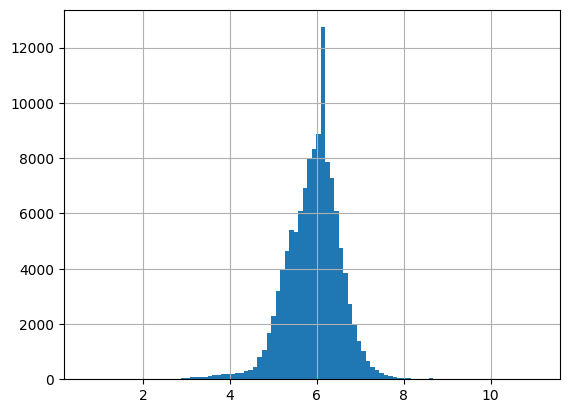

In [19]:
train['Y1'].hist(bins = 100)

<Axes: >

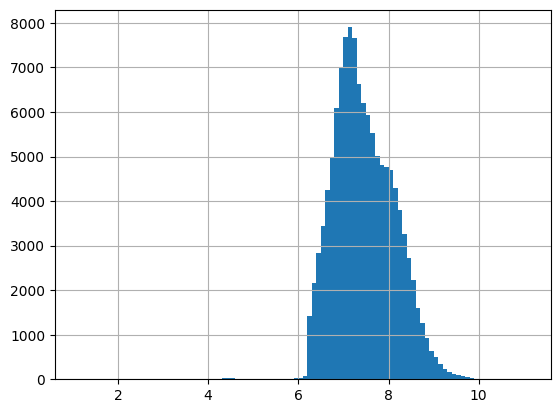

In [20]:
train['Y2'].hist(bins = 100)

<Axes: >

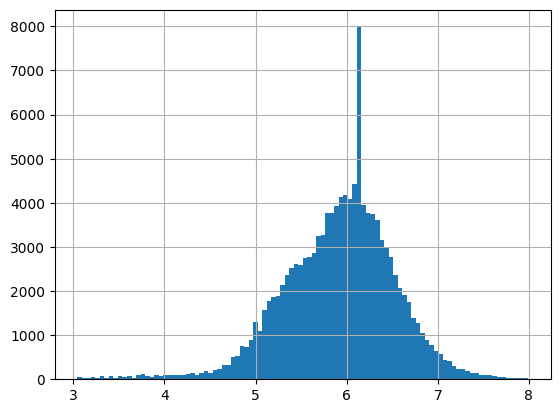

In [21]:
train = train[(train['Y1'] > 3) & (train['Y1'] < 9)]
train['Y1'].hist(bins=100)

<Axes: >

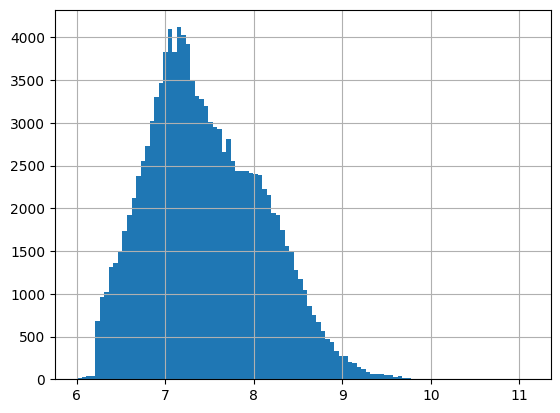

In [22]:
train = train[(train['Y2'] > 4) & (train['Y1'] < 10)]
train['Y2'].hist(bins=100)

## CatBoost

In [23]:
cat_y1 = CatBoostRegressor(loss_function='MAE',
                           cat_features=['X8'],  # Add categorical features index if any
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y1'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y1.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y1.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    test = test[X_train_reduced.columns]

    cat_pred = cat_y1.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y1 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.4577978	test: 0.4562904	best: 0.4562904 (0)	total: 194ms	remaining: 3m 13s
50:	learn: 0.2489522	test: 0.2505224	best: 0.2505224 (50)	total: 3.75s	remaining: 1m 9s
100:	learn: 0.2093115	test: 0.2113509	best: 0.2113509 (100)	total: 7.17s	remaining: 1m 3s
150:	learn: 0.1973445	test: 0.1995106	best: 0.1995106 (150)	total: 10.4s	remaining: 58.7s
200:	learn: 0.1920219	test: 0.1945238	best: 0.1945238 (200)	total: 13.8s	remaining: 54.7s
250:	learn: 0.1890244	test: 0.1917239	best: 0.1917239 (250)	total: 18s	remaining: 53.8s
300:	learn: 0.1868226	test: 0.1897033	best: 0.1897033 (300)	total: 22.2s	remaining: 51.5s
350:	learn: 0.1852749	test: 0.1882965	best: 0.1882965 (350)	total: 25.8s	remaining: 47.7s
400:	learn: 0.1838550	test: 0.1869781	best: 0.1869781 (400)	total: 29s	remaining: 43.3s
450:	learn: 0.1825362	test: 0.1858005	best: 0.1858005 (450)	total: 32.2s	remaining: 39.1s
500:	learn: 0.1814584	test: 0.1849001	best: 0.1849001 (500)	total: 35.3s	remaining: 35.1s
550:	learn: 0.18057

Processing folds:  20%|██        | 1/5 [01:04<04:17, 64.28s/it]

999:	learn: 0.1752546	test: 0.1799314	best: 0.1799314 (999)	total: 1m 3s	remaining: 0us

bestTest = 0.1799313995
bestIteration = 999

0:	learn: 0.4574415	test: 0.4575823	best: 0.4575823 (0)	total: 56.5ms	remaining: 56.4s
50:	learn: 0.2485135	test: 0.2480304	best: 0.2480304 (50)	total: 2.88s	remaining: 53.5s
100:	learn: 0.2094652	test: 0.2091378	best: 0.2091378 (100)	total: 5.74s	remaining: 51.1s
150:	learn: 0.1976269	test: 0.1970788	best: 0.1970788 (150)	total: 8.75s	remaining: 49.2s
200:	learn: 0.1926632	test: 0.1921492	best: 0.1921492 (200)	total: 11.6s	remaining: 46.1s
250:	learn: 0.1895962	test: 0.1891977	best: 0.1891977 (250)	total: 14.6s	remaining: 43.6s
300:	learn: 0.1875876	test: 0.1873665	best: 0.1873665 (300)	total: 17.7s	remaining: 41s
350:	learn: 0.1859089	test: 0.1858314	best: 0.1858314 (350)	total: 20.7s	remaining: 38.2s
400:	learn: 0.1845577	test: 0.1846139	best: 0.1846139 (400)	total: 24.3s	remaining: 36.3s
450:	learn: 0.1832901	test: 0.1834999	best: 0.1834999 (450)	tot

Processing folds:  40%|████      | 2/5 [02:07<03:10, 63.52s/it]

999:	learn: 0.1758617	test: 0.1775017	best: 0.1775017 (999)	total: 1m 2s	remaining: 0us

bestTest = 0.1775017305
bestIteration = 999

0:	learn: 0.4579033	test: 0.4558106	best: 0.4558106 (0)	total: 74.7ms	remaining: 1m 14s
50:	learn: 0.2490061	test: 0.2456924	best: 0.2456924 (50)	total: 3.5s	remaining: 1m 5s
100:	learn: 0.2102757	test: 0.2065647	best: 0.2065647 (100)	total: 6.64s	remaining: 59.1s
150:	learn: 0.1984418	test: 0.1949538	best: 0.1949538 (150)	total: 9.77s	remaining: 54.9s
200:	learn: 0.1934568	test: 0.1900081	best: 0.1900081 (200)	total: 12.8s	remaining: 50.7s
250:	learn: 0.1905692	test: 0.1871528	best: 0.1871528 (250)	total: 15.8s	remaining: 47.2s
300:	learn: 0.1884643	test: 0.1851472	best: 0.1851472 (300)	total: 18.8s	remaining: 43.7s
350:	learn: 0.1867877	test: 0.1835462	best: 0.1835462 (350)	total: 21.8s	remaining: 40.4s
400:	learn: 0.1852878	test: 0.1821039	best: 0.1821039 (400)	total: 24.9s	remaining: 37.1s
450:	learn: 0.1841376	test: 0.1810070	best: 0.1810070 (450)	t

Processing folds:  60%|██████    | 3/5 [03:07<02:04, 62.22s/it]

999:	learn: 0.1765001	test: 0.1747196	best: 0.1747196 (999)	total: 1m	remaining: 0us

bestTest = 0.1747196092
bestIteration = 999

0:	learn: 0.4562376	test: 0.4618959	best: 0.4618959 (0)	total: 54.5ms	remaining: 54.5s
50:	learn: 0.2485117	test: 0.2519000	best: 0.2519000 (50)	total: 2.99s	remaining: 55.6s
100:	learn: 0.2089057	test: 0.2120785	best: 0.2120785 (100)	total: 5.84s	remaining: 52s
150:	learn: 0.1970754	test: 0.2002487	best: 0.2002487 (150)	total: 8.73s	remaining: 49.1s
200:	learn: 0.1919019	test: 0.1950522	best: 0.1950522 (200)	total: 11.6s	remaining: 46.2s
250:	learn: 0.1889024	test: 0.1922018	best: 0.1922018 (250)	total: 14.5s	remaining: 43.2s
300:	learn: 0.1867897	test: 0.1902681	best: 0.1902681 (300)	total: 17.2s	remaining: 40s
350:	learn: 0.1850799	test: 0.1887099	best: 0.1887099 (350)	total: 20.1s	remaining: 37.1s
400:	learn: 0.1836616	test: 0.1874304	best: 0.1874304 (400)	total: 23s	remaining: 34.3s
450:	learn: 0.1824766	test: 0.1863977	best: 0.1863977 (450)	total: 25.

Processing folds:  80%|████████  | 4/5 [04:06<01:00, 60.75s/it]

999:	learn: 0.1748830	test: 0.1803896	best: 0.1803896 (999)	total: 58s	remaining: 0us

bestTest = 0.1803895674
bestIteration = 999

0:	learn: 0.4577496	test: 0.4556123	best: 0.4556123 (0)	total: 77.8ms	remaining: 1m 17s
50:	learn: 0.2495557	test: 0.2493848	best: 0.2493848 (50)	total: 3.07s	remaining: 57.1s
100:	learn: 0.2094238	test: 0.2099782	best: 0.2099782 (100)	total: 6.21s	remaining: 55.3s
150:	learn: 0.1974159	test: 0.1984052	best: 0.1984052 (150)	total: 9.34s	remaining: 52.5s
200:	learn: 0.1923721	test: 0.1937675	best: 0.1937675 (200)	total: 12.3s	remaining: 48.8s
250:	learn: 0.1893112	test: 0.1909394	best: 0.1909394 (250)	total: 15.5s	remaining: 46.3s
300:	learn: 0.1871133	test: 0.1889660	best: 0.1889660 (300)	total: 19.2s	remaining: 44.7s
350:	learn: 0.1853720	test: 0.1873936	best: 0.1873936 (350)	total: 22.6s	remaining: 41.8s
400:	learn: 0.1838522	test: 0.1861617	best: 0.1861617 (400)	total: 25.9s	remaining: 38.7s
450:	learn: 0.1826340	test: 0.1851373	best: 0.1851373 (450)	to

Processing folds: 100%|██████████| 5/5 [05:08<00:00, 61.76s/it]

999:	learn: 0.1751328	test: 0.1795362	best: 0.1795362 (999)	total: 1m 1s	remaining: 0us

bestTest = 0.1795361532
bestIteration = 999

Validation : MAE scores for each fold: [0.17993239870599642, 0.17752796356043826, 0.1748079383625177, 0.18042073359858604, 0.17955544097065007]
Validation : MAE: 0.17844889503963768


In [24]:
cat_y2 = CatBoostRegressor(loss_function='MAE',
                           cat_features=['X8'],  # Add categorical features index if any
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y2'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y2.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y2.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    cat_pred = cat_y2.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y2 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5175053	test: 0.5177997	best: 0.5177997 (0)	total: 83.6ms	remaining: 1m 23s
50:	learn: 0.2026053	test: 0.2030622	best: 0.2030622 (50)	total: 3.95s	remaining: 1m 13s
100:	learn: 0.1310896	test: 0.1321988	best: 0.1321988 (100)	total: 7.64s	remaining: 1m 7s
150:	learn: 0.1090049	test: 0.1101141	best: 0.1101141 (150)	total: 11.6s	remaining: 1m 5s
200:	learn: 0.1010212	test: 0.1021182	best: 0.1021182 (200)	total: 14.6s	remaining: 57.9s
250:	learn: 0.0971779	test: 0.0983611	best: 0.0983611 (250)	total: 17.7s	remaining: 52.9s
300:	learn: 0.0947235	test: 0.0960430	best: 0.0960430 (300)	total: 20.7s	remaining: 48.1s
350:	learn: 0.0929344	test: 0.0944111	best: 0.0944111 (350)	total: 23.6s	remaining: 43.6s
400:	learn: 0.0915541	test: 0.0931598	best: 0.0931598 (400)	total: 26.4s	remaining: 39.5s
450:	learn: 0.0903863	test: 0.0921193	best: 0.0921193 (450)	total: 29.3s	remaining: 35.6s
500:	learn: 0.0894041	test: 0.0912445	best: 0.0912445 (500)	total: 32.2s	remaining: 32s
550:	learn: 0.0

Processing folds:  20%|██        | 1/5 [01:03<04:13, 63.39s/it]

999:	learn: 0.0842295	test: 0.0867923	best: 0.0867923 (999)	total: 1m 2s	remaining: 0us

bestTest = 0.08679226636
bestIteration = 999

0:	learn: 0.5176240	test: 0.5173127	best: 0.5173127 (0)	total: 72ms	remaining: 1m 11s
50:	learn: 0.2028302	test: 0.2013249	best: 0.2013249 (50)	total: 4.01s	remaining: 1m 14s
100:	learn: 0.1312844	test: 0.1301356	best: 0.1301356 (100)	total: 7.92s	remaining: 1m 10s
150:	learn: 0.1093473	test: 0.1081996	best: 0.1081996 (150)	total: 11.6s	remaining: 1m 5s
200:	learn: 0.1012833	test: 0.1001870	best: 0.1001870 (200)	total: 14.8s	remaining: 58.9s
250:	learn: 0.0972271	test: 0.0961816	best: 0.0961816 (250)	total: 18.1s	remaining: 53.9s
300:	learn: 0.0948299	test: 0.0938587	best: 0.0938587 (300)	total: 21.1s	remaining: 49s
350:	learn: 0.0931592	test: 0.0922531	best: 0.0922531 (350)	total: 24.5s	remaining: 45.4s
400:	learn: 0.0917467	test: 0.0909003	best: 0.0909003 (400)	total: 28s	remaining: 41.8s
450:	learn: 0.0905884	test: 0.0898116	best: 0.0898116 (450)	tot

Processing folds:  40%|████      | 2/5 [02:08<03:13, 64.38s/it]

999:	learn: 0.0845496	test: 0.0843999	best: 0.0843999 (999)	total: 1m 4s	remaining: 0us

bestTest = 0.08439987945
bestIteration = 999

0:	learn: 0.5179116	test: 0.5159601	best: 0.5159601 (0)	total: 68ms	remaining: 1m 7s
50:	learn: 0.2027165	test: 0.2016877	best: 0.2016877 (50)	total: 3.18s	remaining: 59.2s
100:	learn: 0.1309110	test: 0.1303191	best: 0.1303191 (100)	total: 6.18s	remaining: 55s
150:	learn: 0.1092304	test: 0.1086497	best: 0.1086497 (150)	total: 9.04s	remaining: 50.9s
200:	learn: 0.1015403	test: 0.1007686	best: 0.1007686 (200)	total: 11.9s	remaining: 47.3s
250:	learn: 0.0974751	test: 0.0966152	best: 0.0966152 (250)	total: 14.8s	remaining: 44.1s
300:	learn: 0.0952309	test: 0.0943382	best: 0.0943382 (300)	total: 17.6s	remaining: 40.9s
350:	learn: 0.0932096	test: 0.0922797	best: 0.0922797 (350)	total: 20.5s	remaining: 37.9s
400:	learn: 0.0917704	test: 0.0908100	best: 0.0908100 (400)	total: 23.4s	remaining: 35s
450:	learn: 0.0905682	test: 0.0895924	best: 0.0895924 (450)	total:

Processing folds:  60%|██████    | 3/5 [03:07<02:03, 61.80s/it]

999:	learn: 0.0845784	test: 0.0838673	best: 0.0838673 (999)	total: 58.3s	remaining: 0us

bestTest = 0.08386725462
bestIteration = 999

0:	learn: 0.5180441	test: 0.5189812	best: 0.5189812 (0)	total: 70.7ms	remaining: 1m 10s
50:	learn: 0.2017866	test: 0.2031869	best: 0.2031869 (50)	total: 3.1s	remaining: 57.7s
100:	learn: 0.1303129	test: 0.1313867	best: 0.1313867 (100)	total: 6.05s	remaining: 53.8s
150:	learn: 0.1084856	test: 0.1098465	best: 0.1098465 (150)	total: 8.93s	remaining: 50.2s
200:	learn: 0.1006466	test: 0.1021956	best: 0.1021956 (200)	total: 11.7s	remaining: 46.6s
250:	learn: 0.0965856	test: 0.0983041	best: 0.0983041 (250)	total: 14.6s	remaining: 43.5s
300:	learn: 0.0942429	test: 0.0960655	best: 0.0960655 (300)	total: 17.4s	remaining: 40.4s
350:	learn: 0.0925052	test: 0.0943727	best: 0.0943727 (350)	total: 20.2s	remaining: 37.4s
400:	learn: 0.0911793	test: 0.0930702	best: 0.0930702 (400)	total: 23.1s	remaining: 34.5s
450:	learn: 0.0900669	test: 0.0920078	best: 0.0920078 (450)	

Processing folds:  80%|████████  | 4/5 [04:05<01:00, 60.38s/it]

999:	learn: 0.0841311	test: 0.0863479	best: 0.0863479 (999)	total: 57.8s	remaining: 0us

bestTest = 0.08634787469
bestIteration = 999

0:	learn: 0.5174082	test: 0.5185326	best: 0.5185326 (0)	total: 64.5ms	remaining: 1m 4s
50:	learn: 0.2015984	test: 0.2029351	best: 0.2029351 (50)	total: 3.06s	remaining: 56.9s
100:	learn: 0.1302020	test: 0.1305415	best: 0.1305415 (100)	total: 6.07s	remaining: 54s
150:	learn: 0.1088823	test: 0.1092674	best: 0.1092674 (150)	total: 9.02s	remaining: 50.7s
200:	learn: 0.1012679	test: 0.1018364	best: 0.1018364 (200)	total: 11.8s	remaining: 47.1s
250:	learn: 0.0972818	test: 0.0979094	best: 0.0979094 (250)	total: 14.8s	remaining: 44s
300:	learn: 0.0947435	test: 0.0954559	best: 0.0954559 (300)	total: 17.7s	remaining: 41.2s
350:	learn: 0.0930096	test: 0.0937878	best: 0.0937878 (350)	total: 20.9s	remaining: 38.7s
400:	learn: 0.0916094	test: 0.0924362	best: 0.0924362 (400)	total: 24.3s	remaining: 36.3s
450:	learn: 0.0904460	test: 0.0913245	best: 0.0913245 (450)	tota

Processing folds: 100%|██████████| 5/5 [05:08<00:00, 61.61s/it]

999:	learn: 0.0844157	test: 0.0858191	best: 0.0858191 (999)	total: 1m 2s	remaining: 0us

bestTest = 0.08581911622
bestIteration = 999

Validation : MAE scores for each fold: [0.08679326498008924, 0.08440088070533443, 0.0845492838451849, 0.08655091431932672, 0.08597985666247722]
Validation : MAE: 0.0856548401024825


## MLJAR

In [ ]:
!pip install mljar-supervised

In [ ]:
categorical_features = ['X8']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

In [ ]:
from supervised.automl import AutoML

train_x1 = train.drop(['Y1', 'Y2'], axis=1)
train_x2 = train.drop(['Y1', 'Y2'], axis=1)

train_y1 = train['Y1']
train_y2 = train['Y2']


Cross_validation = {
    "validation_type": "kfold",
    "k_folds": 10,
    "shuffle": True,
    "random_seed": 112
}

In [ ]:
automl_y1 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit = 1800 * 2 * 5)
automl_y1.fit(train_x1, train_y1)

In [ ]:
automl_y2 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit=1800 * 2 * 5)
automl_y2.fit(train_x2, train_y2)

In [ ]:
pred_y1 = automl_y1.predict_all(test)
pred_y2 = automl_y2.predict_all(test)

In [ ]:
final_predictions = (np.expm1(pred_y1)) + (np.expm1(pred_y2))

## 제출

In [25]:
submit = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\sample_submission.csv')

submit.head()

,Id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [26]:
final_predictions = np.expm1(final_predictions_y1) + np.expm1(final_predictions_y2)


submit.iloc[:, 1] = final_predictions

submit

,Id,Predicted
0,0,2846.524187
1,1,1679.177039
2,2,3177.269361
3,3,4109.579536
4,4,1357.320755
...,...,...
40566,40566,837.756102
40567,40567,1316.875178
40568,40568,2173.084496
40569,40569,1130.670104


In [27]:
submit.to_csv('C:\\Users\\dlwks\\OneDrive\\바탕 화면\\VSCode\\HD_CNC\\1125-4.csv', index=False)